In [1]:
import torch
import os
import requests
import zipfile
from pathlib import Path
from torch.utils.data import dataloader
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset
import pathlib
import torchvision

In [2]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"



train_dir = image_path / "train"
test_dir = image_path / "test"

In [3]:
def walk_through(dir_path):
    '''
    arg  : get the directory path 
    return :  the content of the directory 
    
    '''
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'The are {len(dirnames)} directories and {len(filenames)} in the {dirpath}')
        

In [4]:
### data augmentation scheme
data_transform = transforms.Compose([
    #resize the image
    transforms.Resize(size=(64,64)),
    ## random flip
    transforms.RandomHorizontalFlip(p = 0.5),
    #tensor conversion 
    transforms.ToTensor()
])


In [5]:
def plot_tranformed_images(image_paths, transforms, n=3, seed = 42):
    """ plots a series of random images from the image paths 
    and it's corresponding transformed imgaes """
    random.seed(seed)
    
    random_image_paths = random.sample(image_paths, n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax  = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f'original size {f.size}')
            ax[0].axis('off')
            
            transformed_imag = transforms(f).permute(1,2,0)
            ax[1].imshow(transformed_imag)
            ax[1].set_title(f'original size {transformed_imag.shape}')
            ax[1].axis('off')
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

In [6]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

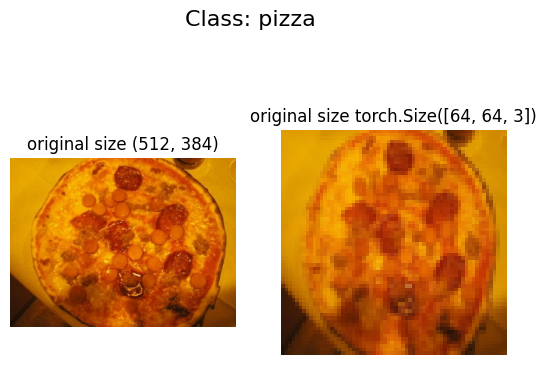

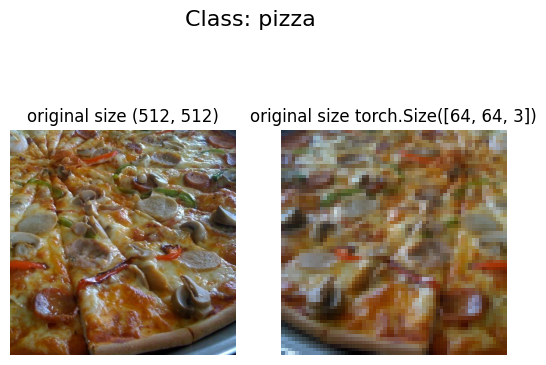

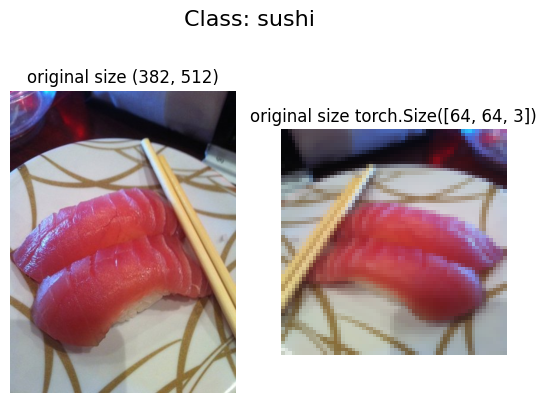

In [7]:
plot_tranformed_images(image_path_list, data_transform, n=3)

In [8]:
## loading the datsets using torcvision datasets as the datasets is seprated as image class folders

train_data = torchvision.datasets.ImageFolder(root= train_dir,
                                  transform=data_transform,
                                  target_transform=None)   ## in here target transforms mean any transformation done to the label of the data (targets are labels)
 
test_data = torchvision.datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

In [9]:
print(f'Train data:\n {train_data} \n Test data:\n {test_data}') ## this will print out about the dataset in use and relevant transforms applied along with how many train and test data available 

Train data:
 Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           ) 
 Test data:
 Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [10]:
class_names = train_data.classes ## to get the class names
class_names 

['pizza', 'steak', 'sushi']

In [11]:
## data loader
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=1, num_workers=1, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, num_workers=1, shuffle=True)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7fef8990f340>,
 <torch.utils.data.dataloader.DataLoader at 0x7fef8bc4bd90>)

In [12]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [13]:
from typing import Tuple, Dict, List

In [14]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

Now we will look at how to use a custom data folder 

    First we need to subclass the dataset using Dataset
    so we initialise the the dataset class with the target directory and transform 
    then add the relevant attributes such as 
        the transform attr
        data path attr
        and class attr
    


In [15]:
from torch.utils.data import Dataset
import pathlib

In [16]:
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, transforms=None) -> None:
        ### creating all the class attributes
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.transform = transforms
        self.classes, self.class_to_idx = find_classes(targ_dir)
        
    
    def load_image(self, index:int) -> Image.Image:
        '''opens an image via path and returns it through this function'''
        image_path = self.paths[index]
        return Image.open(image_path)
        
    def __len__(self) -> int:
        '''returns the total number of data'''
        return len(self.paths)
    
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_names = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_names]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [17]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])


test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])


In [18]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, transforms=train_transform)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, transforms=test_transform)

train_data_custom, test_data_custom ## these two return the dataset object which we created the custom dataset class

(<__main__.ImageFolderCustom at 0x7fef89987dc0>,
 <__main__.ImageFolderCustom at 0x7fef89986770>)

In [19]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [20]:
train_data_custom.classes, test_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'],
 ['pizza', 'steak', 'sushi'],
 {'pizza': 0, 'steak': 1, 'sushi': 2})

In [21]:
print(random.sample(range(len(train_data_custom)), 4))
for i, j  in enumerate(random.sample(range(len(train_data_custom)), 4)):
    print(i,  j)

[62, 57, 35, 188]
0 26
1 173
2 189
3 139


plotting the data images using a dedcated function 

In [22]:
def display_random_images(dataset : torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n :int = 10, # to mention the number of images to display
                          display_shape: bool = True, 
                          seed : int = None):
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    if seed:
        random.seed(seed)
    
    ## return the indexes of the random samples selected
    random_sample_idx = random.sample(range(len(dataset)), k = n) # k here is to mention how many samples to pick from the dataset object
    
    plt.figure(figsize=(16, 8))
    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_class = dataset[targ_sample][0], dataset[targ_sample][1]
        
        targ_image_adjust = targ_image.permute(1,2,0)
        
        ## plot the adjusted sampels
        plt.subplot(1, n, i + 1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_class]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

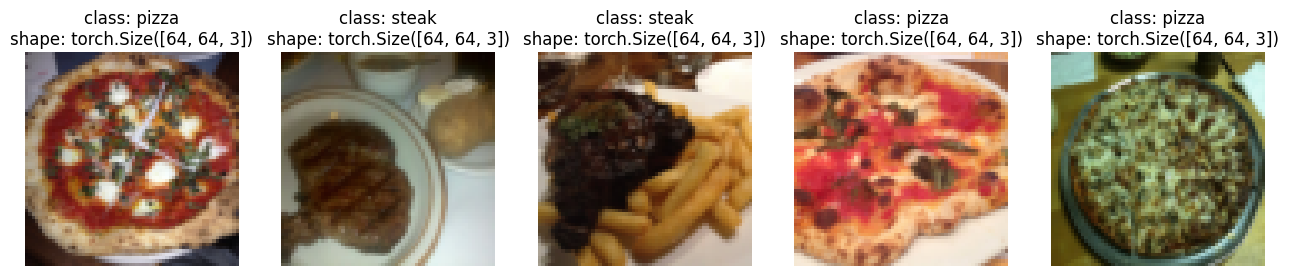

In [23]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


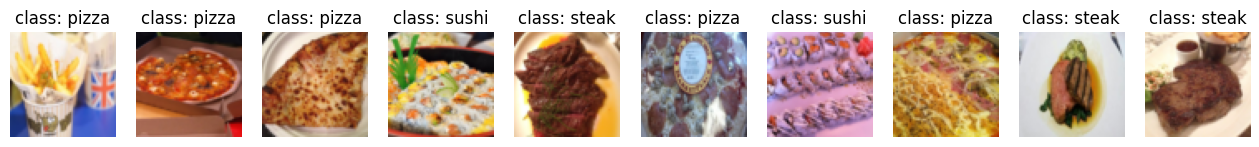

In [24]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom, 
                      n=12, 
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

In [25]:
## making the dataloaders
from torch.utils.data import DataLoader

train_dataloader_custom  = DataLoader(dataset=train_data_custom, 
                                      batch_size=1, 
                                      num_workers=0, 
                                      shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom, 
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fef8ba84430>,
 <torch.utils.data.dataloader.DataLoader at 0x7fef8ba84e20>)

In [26]:
## one iteration of the dataloader

img_custom, label_custom = next(iter(train_dataloader_custom))
print(f'image shape is - {img_custom.shape} the img class shape is {label_custom.shape}')

image shape is - torch.Size([1, 3, 64, 64]) the img class shape is torch.Size([1])


In [27]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=34),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

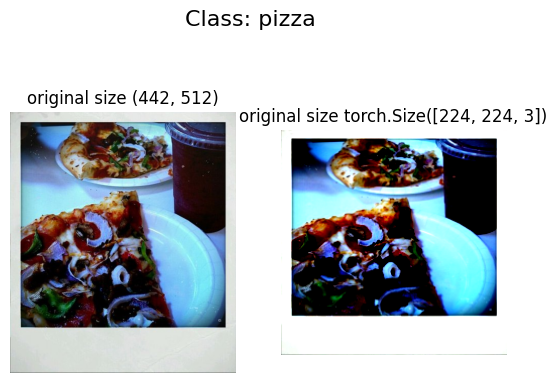

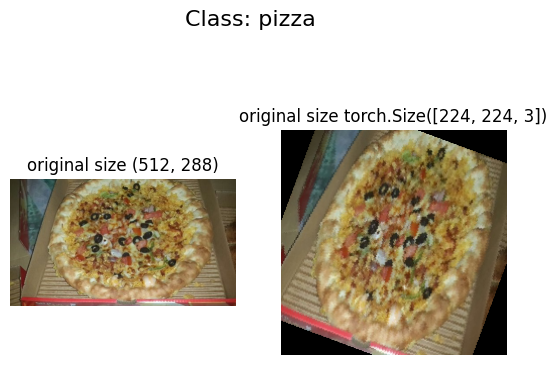

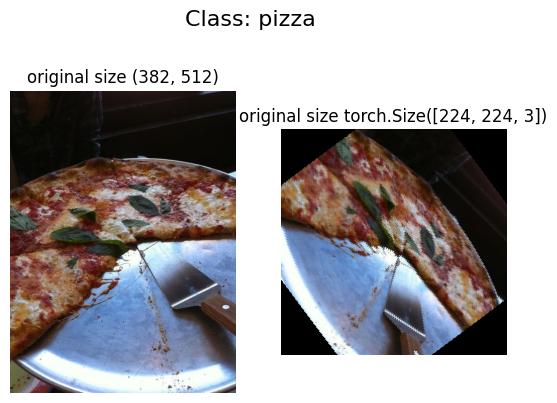

In [28]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

plot_tranformed_images(
    image_paths=image_path_list,
    transforms=train_transform,
    n =3,
    seed=None
)

In [29]:
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

In [30]:
###hyper parameters
import torch.nn as nn
BATCH_SIZE = 32
NUM_WORKER = os.cpu_count()

In [31]:
### loading the datasets
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir, transform=simple_transform )
test_data = datasets.ImageFolder(root = test_dir, transform=simple_transform)

##dataloader
import os
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers= NUM_WORKER, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKER, shuffle=False)

In [116]:
## we will use the tinyVGG model architecture for the classification task 

class TinyVGG(nn.Module):
    """model architecture tinu VGG  - https://arxiv.org/pdf/2004.15004"""
    
    def __init__(self, input_shape :int ,hidden_units :int,  output_shape: int, ) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9610, out_features=3)
        )
        
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [117]:
len(train_data.classes)

3

In [118]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, 
                  hidden_units=10,
                  output_shape= len(train_data.classes)).to('cuda')

In [119]:
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9610, out_features=3, bias=True)
  )
)

In [120]:
x = torch.tensor([1, 2, 3, 4])
x.size()

torch.Size([4])

In [121]:
x = torch.unsqueeze(x, 0)
x.size()

torch.Size([1, 4])

In [133]:
image, label = next(iter(train_loader))

img_single, label_single = image[0].unsqueeze(dim=0), label[0]

model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to('cuda'))

In [134]:
print(f'output logits {pred}')
print(f'output prediction probabilities  {torch.softmax(pred, dim=1)}')
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f' the acutal label is -: {label_single}') ### ooo lucky here

output logits tensor([[-0.0526, -0.0130,  0.0307]], device='cuda:0')
output prediction probabilities  tensor([[0.3198, 0.3327, 0.3475]], device='cuda:0')
Output prediction label:
tensor([2], device='cuda:0')

 the acutal label is -: 0


In [136]:
from torchinfo import summary
summary(model_0, input_size = [1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 63, 63]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 63, 63]           --
├─Sequential: 1-2                        [1, 10, 31, 31]           --
│    └─Conv2d: 2-6                       [1, 10, 63, 63]           910
│    └─ReLU: 2-7                         [1, 10, 63, 63]           --
│    └─Conv2d: 2-8                       [1, 10, 63, 63]           910
│    └─ReLU: 2-9                         [1, 10, 63, 63]           --
│    └─MaxPool2d: 2-10                   [1, 10, 31, 31]           --
├─Sequentia

In [ ]:
### making the train step

